# Training classifiers on the Breast Cancer dataset

## Feature engineering

In [20]:
import pandas as pd
# Load the data set
df = pd.read_csv('../input/data.csv')

In [21]:
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [22]:
# drop ID - we don't need that
df.drop('id',axis=1,inplace=True)
# there's an additional column 'unnamed' with no data. delete as well
df.drop('Unnamed: 32',axis=1,inplace=True)

In [23]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
radius_mean,569.0,14.127292,3.524049,6.981000,11.700000,13.370000,15.780000,28.11000
texture_mean,569.0,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.28000
perimeter_mean,569.0,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.50000
area_mean,569.0,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.00000
smoothness_mean,569.0,0.096360,0.014064,0.052630,0.086370,0.095870,0.105300,0.16340
compactness_mean,569.0,0.104341,0.052813,0.019380,0.064920,0.092630,0.130400,0.34540
concavity_mean,569.0,0.088799,0.079720,0.000000,0.029560,0.061540,0.130700,0.42680
concave points_mean,569.0,0.048919,0.038803,0.000000,0.020310,0.033500,0.074000,0.20120
symmetry_mean,569.0,0.181162,0.027414,0.106000,0.161900,0.179200,0.195700,0.30400
fractal_dimension_mean,569.0,0.062798,0.007060,0.049960,0.057700,0.061540,0.066120,0.09744


In [24]:
# check for missing data
all_data_na = (df.isnull().sum() / len(df)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio


no missing values in this data set. Nice :)

In [25]:
from scipy.stats import skew 

# find skewed features
numeric_feats = df.dtypes[df.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = df[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)

,Skew
area_se,5.432816
concavity_se,5.096981
fractal_dimension_se,3.913617
perimeter_se,3.434530
radius_se,3.080464
smoothness_se,2.308344
symmetry_se,2.189342
compactness_se,1.897202
area_worst,1.854468
fractal_dimension_worst,1.658193


In [26]:
# "unskew" the features
skewness = skewness[abs(skewness) > 0.75]

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    df[feat] = boxcox1p(df[feat], lam)

In [27]:
# Replace the target values (M = malignant, B = benign) with 1 for malignant and 0 for begnin tumors
df['diagnosis']= df['diagnosis'].map({'M':1,'B':0})

In [28]:
# split into target (y) and features (X)
y = df['diagnosis']
X = df.drop('diagnosis',axis=1)

In [29]:
# Scale the feature values
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)

In [30]:
# and split into train and test data sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Train models

First define some functions for code that we'll use a few times for training models

In [31]:
import numpy as np

# scoring function for the model
# we score with the mean AUC from 5 folds of the training data
from sklearn.model_selection import KFold, cross_val_score
def score_model(model):
    kf = KFold(5, shuffle=True, random_state=42).get_n_splits(X_train)
    model_score = np.mean(cross_val_score(model, X_train, y_train, scoring="recall", cv = kf))
    return((type(model).__name__,model_score))

Now let's loop through some classifier models with standard hyper parameters and check the scores for each of them

In [32]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier

model_scores = pd.DataFrame(columns=['model','Recall score'])
clfs = [KNeighborsClassifier(),  MLPClassifier(), SVC(), GaussianProcessClassifier(), DecisionTreeClassifier()
        , RandomForestClassifier(), AdaBoostClassifier(), GaussianNB(), QuadraticDiscriminantAnalysis(), XGBClassifier()]
for clf in clfs:
    sc = score_model(clf)
    model_scores = model_scores.append({'model':sc[0],'Recall score':sc[1]},ignore_index=True)    

/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt

In [34]:
model_scores.sort_values('Recall score',ascending=False)

,model,Recall score
2,SVC,0.961895
1,MLPClassifier,0.942742
8,QuadraticDiscriminantAnalysis,0.942742
9,XGBClassifier,0.936290
6,AdaBoostClassifier,0.929637
0,KNeighborsClassifier,0.923387
3,GaussianProcessClassifier,0.911290
7,GaussianNB,0.904839
4,DecisionTreeClassifier,0.904637
5,RandomForestClassifier,0.891935


SVC, MLP are the top performers. We'll tune the hyperparameters for these two next to squeeze out the maximum score.

## Hyperparameter tuning
I'm doing the hyperparameter tuning with GridSearch for each of the three top performing standard models seperately.

In [35]:
# SVC
from sklearn.model_selection import GridSearchCV

parameter_space = {
    'C': np.logspace(-2, 10, 20,base=2),
    'gamma': np.logspace(-9, 3, 13),
}
grid_search = GridSearchCV(SVC(kernel='rbf'), parameter_space, n_jobs=-1, cv=5,scoring="recall")
grid_search.fit(X_train, y_train)
grid_search.best_params_

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'C': 47.80028677294353, 'gamma': 0.001}

In [36]:
# MLP
parameter_space = {
    'hidden_layer_sizes': [(20,20), (100,), (50,), (30,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
grid_search = GridSearchCV(MLPClassifier(), parameter_space, n_jobs=-1, cv=5,scoring="recall")
grid_search.fit(X_train, y_train)
grid_search.best_params_

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


{'activation': 'relu',
 'alpha': 0.0001,
 'hidden_layer_sizes': (30,),
 'learning_rate': 'adaptive',
 'solver': 'adam'}

Now let's take a final look at the scores for the tuned models.

In [38]:
model_scores = pd.DataFrame(columns=['model','Recall score'])
clfs = [SVC(kernel="rbf", gamma=0.001, C=47),MLPClassifier(max_iter=300,activation='relu',
                                                         hidden_layer_sizes=(30,),alpha=0.0001, learning_rate="adaptive",
                                                        solver="adam")]
for clf in clfs:
    sc = score_model(clf)
    model_scores = model_scores.append({'model':sc[0],'Recall score':sc[1]},ignore_index=True) 

/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt

In [39]:
model_scores

,model,Recall score
0,SVC,0.968347
1,MLPClassifier,0.955444


We were able to increase the recall scores a bit.

## Train the final model, validate and results

In [42]:
# train and then validate with the test data set
from sklearn.metrics import recall_score

clf = SVC(kernel="rbf", gamma=0.001, C=47)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Test Recall: {}".format(recall_score(y_test, y_pred)))


Test Recall: 0.9814814814814815


In [43]:
# calculate the confusion matrix
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_test,y_pred)

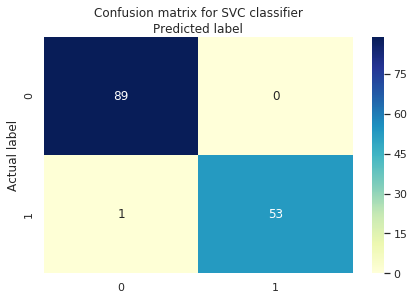

In [44]:
# Confusion matrix with Seaborn
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

class_names = [0,1]
fig,ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks,class_names)
plt.yticks(tick_marks,class_names)

#create a heat map
sns.heatmap(pd.DataFrame(cnf_matrix), annot = True, cmap = 'YlGnBu',
           fmt = 'g')
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.title('Confusion matrix for SVC classifier', y = 1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

1. The final classifier is has one false negatives and no false positives out of a total of 143 validation samples

In [45]:
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
print("Precision: {}".format(precision_score(y_test,y_pred)))
print("Accuracy: {}".format(accuracy_score(y_test,y_pred)))

Precision: 1.0
Accuracy: 0.993006993006993


Accuracy is 99.3%